## Попробуем CatBoost, подбор гиперпараметров Optuna

##  Нюанс тот же ...

Данные имеют временные метки. 
Соответственно, split обязательно должен быть по времени.
- и при разделении на train - test
- и при кроссвалидации.
  
Так же и нормализовывать данные необходимо после разбиения.
- однако в этом случае качество моделей падает ниже плинтуса, то на эту утечку пока забью...)

## 1. Импорты

In [1]:
# Импорт библиотек
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                            precision_recall_curve, auc, confusion_matrix)

import optuna
from optuna.samplers import TPESampler
import catboost as cb

import time
import warnings
warnings.filterwarnings('ignore')

# Конфигурация
RANDOM_STATE = 42
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

## 2. Загрузка данных

In [2]:
# поиск пути от текущего файла в папку 
# anomaly_detection_project\data\raw где лежит датасет
def find_path_within_project(project_name, path_to_data):
    current_path = os.getcwd()   # путь к текущему файлу
  
    while True:
        # Проверяем, находится ли проект в текущем каталоге
        # если найден лепим и возвращаем нужный путь к данным
        if project_name in os.listdir(current_path):
            # Строим путь до нужной папки внутри проекта
            return os.path.join(current_path, project_name, path_to_data)
        
        parent_path = os.path.dirname(current_path)
        
        if parent_path == current_path:
            raise FileNotFoundError(f"Проект '{project_name}' не найден в родительских каталогах.")
        # если проекта нет поднимаемся выше
        current_path = parent_path

# Получаем путь
full_path_to_cc_1_02_00 = find_path_within_project(
    "anomaly_detection_project", 
    os.path.join("data", "raw",'creditcard_1_02_00.csv' )
)

In [3]:
# файл creditcard_1_02_00.csv лежит в папке data/raw/
# там добавлены новые колонки времени и суммы 
# print(f"Загрузка данных из {full_path}")
df = pd.read_csv(full_path_to_cc_1_02_00)

# посмотрим ка
print("\n")
print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")
print(f"\nДанные. Первые строки:")
display(df.head())
print("Список колонок без PCA: \n", *df.columns[~df.columns.str.startswith('V')])



Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Данные. Первые строки:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,Time_hour,Time_day,Time_abs_hour,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,0.0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,0.0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0,0.0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0,0.0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0,0.0,4.262539


Список колонок без PCA: 
 Time Amount Class Time_hour Time_day Time_abs_hour Amount_log


## 3. Выделение test

In [4]:
# колонка для сплита
time_column = 'Time_abs_hour'
df[time_column].min(), df[time_column].max()

(0.0, 47.0)

In [5]:
# Выделим для теста последние 8 часов
def get_train_test(df, col, train_finish,
                   train_start = 0, test_finish = 0, gap = 0,
                   easy_check =True):
    '''делим df на train и test 
        - gap -зазор между train и test (возможно и не пригодиццо)
    '''
    # определяем test_start и test_finish
    if test_finish == 0:
        test_finish = df[col].max()
    test_start = train_finish + gap + 1
    df_train = df[(df[col] >= train_start) & (df[col] <= train_finish)]
    df_test =  df[(df[col] >= test_start) & (df[col] <= test_finish)]
    if  easy_check:
        print("easy checking: \n",
              f"train min {df_train[col].min()}, train max {df_train[col].max()}\n" , 
              f"test min {df_test[col].min()}, test max {df_test[col].max()}")
    return df_train, df_test

# делим на трейн тест
time_col = 'Time_abs_hour'
train_finish = df[time_col].max() - 8
df_train, df_test = get_train_test(df, time_col , train_finish)
print("Отрезали тестовую выборку.")
print(f"Размеры train:{df_train.shape} test: {df_test.shape} .")


easy checking: 
 train min 0.0, train max 39.0
 test min 40.0, test max 47.0
Отрезали тестовую выборку.
Размеры train:(224865, 35) test: (59942, 35) .


In [6]:
# делаем ещё один тайм сплит для подбора гиперпараметров 
# можно конечно в оптуну загрузить и time кросс-валидацию но и так должно сработать...
train_finish_2 = df_train[time_col].max() - 8
df_train_2, df_val = get_train_test(df_train, time_col , train_finish_2)
print("Порезали тренировочную выборку.")
print(f"Размеры train:{df_train_2.shape} val: {df_val.shape} .")

easy checking: 
 train min 0.0, train max 31.0
 test min 32.0, test max 39.0
Порезали тренировочную выборку.
Размеры train:(162525, 35) val: (62340, 35) .


## 4. Подготовка данных для обучения

In [7]:
print("Данные содержат колонки: ", df_train_2.columns)

Данные содержат колонки:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Time_hour', 'Time_day', 'Time_abs_hour', 'Amount_log'],
      dtype='object')


In [8]:
# для обучения  предсказания ни временные колонки ни величина транзакций нам не нужны
# кроме PCA колонокн ничего оставлять не будем
unnecessary_cols = ['Time', 'Amount', 'Time_hour', 'Time_day', 'Amount_log', 'Time_abs_hour'] 

In [9]:
# для предсказания оставляем только колонки с PCA признаками
# Предобработка
target_col = "Class"
drop_cols = [target_col] + unnecessary_cols

X_train = df_train_2.drop(drop_cols, axis=1)
y_train = df_train_2[target_col]

X_val = df_val.drop(drop_cols, axis=1)
y_val = df_val[target_col]


X_test = df_test.drop(drop_cols, axis=1)
y_test = df_test[target_col]

# Для тренировки по вснму трейну
X = df_train.drop(drop_cols, axis=1)
y = df_train[target_col]

In [10]:
print("Данные содержат колонки: ", X_train.columns)

Данные содержат колонки:  Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')


## 5. Подбор гиперпараметров и обучение на всём train

In [11]:
# CatBoost силён в работе с категориальными признаками,
# но в данном датасете их нет... можно конечно смастерить , но не будем...
cat_features = []

In [12]:
# Если модель слишком "запомнит" тренировочные данные, то score на train будет сильно больше score на val.
# штрафуем результат на валидации за такой разрыв 
ALPHA = 0.2

def objective(trial):
    params = {
        "loss_function": "Logloss",      # функция потерь для бинарной классификации
        "eval_metric": "PRAUC",          # metric - prauc
        "verbose": 0,                    # что бы не болтал
        "early_stopping_rounds": 30,    # Ранняя остановка, если качество не улучшается 30 итераций
        "random_seed": RANDOM_STATE,

        # основные
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 10),          #  глкбина дерева
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 20, log=True),  # L2-регуляризация весов листьев чем больше тем сильнее
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),  # минимальный объём листа
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),      # Доля случайных объектов для каждой итерации 
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),   #  Доля случайных признаков на каждом уровне дерева.

        # не сильно основные
        # случайность выборки объектов 0-детерминировано  >0 - случайно
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),    
        # cлучайность при выборе разбиений.
        "random_strength": trial.suggest_float("random_strength", 1e-2, 10, log=True),
        # алгоритм роста деревьев
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        # Кол-во шагов уточнения весов в листьях.
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 5)
    }

    train_pool = cb.Pool(X_train, y_train, cat_features=cat_features)
    eval_pool  = cb.Pool(X_val,  y_val,  cat_features=cat_features)

    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=eval_pool, use_best_model=True)

    # Проверка разрыва(переобучения)
    y_tr_pred = model.predict_proba(train_pool)[:, 1]
    y_val_pred = model.predict_proba(eval_pool)[:, 1]

    pr_tr, rec_tr, _  = precision_recall_curve(y_train, y_tr_pred)
    auc_tr = auc(rec_tr, pr_tr)

    pr_val, rec_val, _ = precision_recall_curve(y_val, y_val_pred)
    auc_val = auc(rec_val, pr_val)

    # Штраф за переобучение
    alpha = ALPHA
    gap = max(auc_tr - auc_val, 0.0)
    score = auc_val - alpha * gap

    return score

In [13]:
# подбор гиперпараметров
# создаём исследование Optuna
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=RANDOM_STATE)
)

# Запускаем оптимизацию
N_TRIALS =  9 # можно увеличить для лучшего поиска ~50-200
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

# Лучшие гиперпараметры
print('-'*60)
print("\n   Лучшие гиперпараметры")
print(study.best_params)
print("Лучшая метрика:", study.best_value)

[I 2025-08-25 22:10:19,415] A new study created in memory with name: no-name-d68b49a3-1292-45bc-ba2b-e21ab439b098


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-08-25 22:10:22,945] Trial 0 finished with value: 0.6871714432094351 and parameters: {'learning_rate': 0.008468008575248327, 'depth': 10, 'l2_leaf_reg': 2.6081583694317696, 'min_data_in_leaf': 34, 'subsample': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'bagging_temperature': 0.05808361216819946, 'random_strength': 3.9676050770529883, 'grow_policy': 'Depthwise', 'leaf_estimation_iterations': 5}. Best is trial 0 with value: 0.6871714432094351.
[I 2025-08-25 22:10:23,887] Trial 1 finished with value: 0.7292087015607351 and parameters: {'learning_rate': 0.11536162338241392, 'depth': 4, 'l2_leaf_reg': 0.039829941698924086, 'min_data_in_leaf': 17, 'subsample': 0.6521211214797689, 'colsample_bylevel': 0.762378215816119, 'bagging_temperature': 0.43194501864211576, 'random_strength': 0.07476312062252301, 'grow_policy': 'SymmetricTree', 'leaf_estimation_iterations': 2}. Best is trial 1 with value: 0.7292087015607351.
[I 2025-08-25 22:10:27,338] Trial 2 finished with valu

In [14]:
# мастерим лучшие параметры
best_params = study.best_params
best_params.update({
    "loss_function": "Logloss",
    "verbose": 0,
    "random_seed": RANDOM_STATE,
    # eval_metric можно не добавлять, т.к. eval_set=None
})

# Создаём финальную модель
final_model = cb.CatBoostClassifier(**best_params)


# обучаем на всём трейне
final_model.fit(
    cb.Pool(X, y, cat_features=cat_features),
    eval_set=None,          # early stopping больше не нужен
    use_best_model=False    # используем заданное количество деревьев
)

## 5. Оценка

In [15]:
# Оценка на тесте 
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

#  PR_AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
prauc = auc(recall, precision)
print(f"PR-AUC на тесте: {prauc:.4f}")

# ROC_AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC на тесте: {roc_auc}")

PR-AUC на тесте: 0.8165

ROC-AUC на тесте: 0.9863827811710547


In [16]:
# precision-recall кривая и confusion_matrix и метрики
# метрики печать и возвращаем f1, pr_auc
def print_metrics(y_true, y_pred,  pr_auc):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('\n'+'='*60)
    print(f"Precision={precision:.2f},   Recall={recall:.2f},   F1={f1:.2f},   PR_AUC={pr_auc:.2f}")
    print('\n'+'='*60)
    # return f1, pr_auc

# precision-recall кривая и confusion_matrix
def plot_pr_curve_and_conf_matrix(model, X, y_true, main_label = ''):
    # 0) получаем предсказания и сырые и не очень)
    # получаем сырые оценки 
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X)
    else:
        y_scores = model.predict_proba(X)[:, 1]
    
    # и предсказания
    y_pred = model.predict(X)

    # 1) оценка pr_curve
    precisions, recalls, _ = precision_recall_curve(y_true, y_scores)
    # x  должен монотонно возрастать!!!!
    pr_auc = auc(x = recalls, y = precisions)

    # 2)отрисовка
    # # Создаём общую фигуру с 2 подграфиками (по горизонтали)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    # pr curve
    fig.suptitle("Оценка модели " + main_label, fontsize=14, fontweight='bold')
    
    
    labels = ['Норм (0)', 'Аномалии (1)']
    
    axs[0].plot(recalls, precisions, marker='.', color='teal')
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")
    
    # cm
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_xlabel("Предсказаные метки")
    axs[1].set_ylabel("Истинные метки")
    axs[1].set_title("Confusion Matrix")
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3) # раздвигаем картинки
    plt.show()
    
    # 3) печать метрик
    print_metrics(y_true, y_pred,  pr_auc)
    
    pass


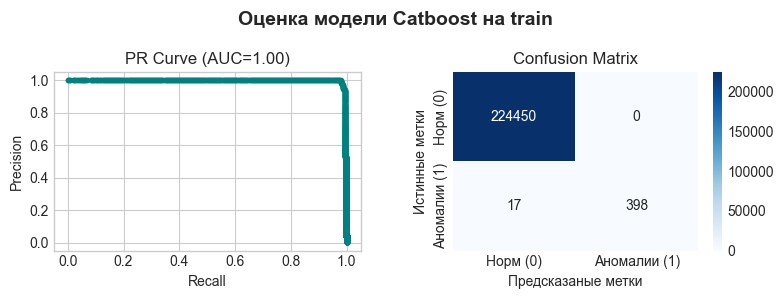


Precision=1.00,   Recall=0.96,   F1=0.98,   PR_AUC=1.00



In [17]:
# Оценка на train
plot_pr_curve_and_conf_matrix(
    final_model, 
    X,
    y,'Catboost на train' 
)

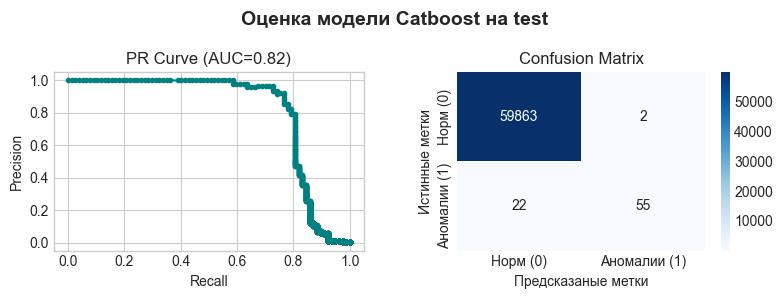


Precision=0.96,   Recall=0.71,   F1=0.82,   PR_AUC=0.82



In [18]:
# Оценка на test
plot_pr_curve_and_conf_matrix(
    final_model, 
    X_test,
    y_test,'Catboost на test' 
)

## 6. Пробуем CatBoost с дефолтными параметрами

In [19]:
f_model = cb.CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE)

# обучаем на всём трейне
f_model.fit(
    cb.Pool(X, y, cat_features=cat_features),
    eval_set=None,          # early stopping больше не нужен
    use_best_model=False    # используем заданное количество деревьев
)

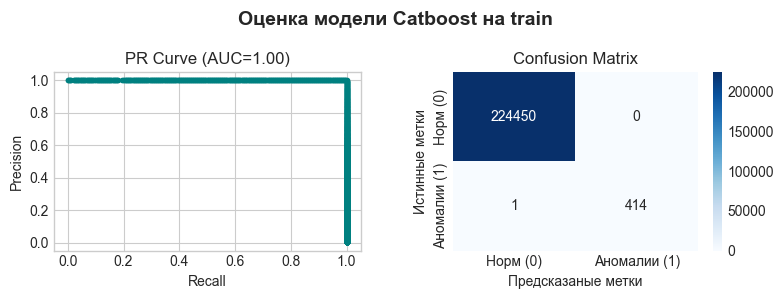


Precision=1.00,   Recall=1.00,   F1=1.00,   PR_AUC=1.00



In [20]:
# Оценка на train
plot_pr_curve_and_conf_matrix(
    f_model, 
    X,
    y,'Catboost на train' 
)

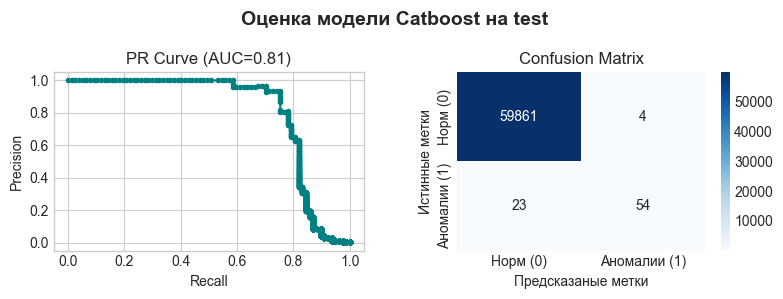


Precision=0.93,   Recall=0.70,   F1=0.80,   PR_AUC=0.81



In [21]:
# Оценка на test
plot_pr_curve_and_conf_matrix(
    f_model, 
    X_test,
    y_test,'Catboost на test' 
)

## 7. Выводы

**Датасет**
- **Объём**: 284 807 транзакций, 35 признаков.
- **Ну очень сильный дисбаланс**: 0,17% транзакций — мошеннические (Class == 1).

**Временное разбиение**: данные разделены по `Time_abs_hour`:
  - **Train**: 0–39 часов (224 865 строк).  
  - **Test**: 40–47 часов (59 942 строк).
  
**Модель**  
- **CatBoost**
  
**Подбор гиперпараметров**
- **Optuna**
  
**Метрики**  | F1   | PR AUC |
- **Train**   | 1 | 1  |
- **Test**     | 0.82 | 0.82   |
  
  
**Вывод**
- - **Supervised-подход по прежнему кардинально превосходит Unsupervised-подход (LOF)** на этой задаче.
- **CatBoost показал более высокие результаты чем Random Forest**(который уже был не плох) и **Optuna** тоже реально помогла.
- **Эффективность Optuna**: Подбор гиперпараметров с помощью Optuna позволил улучшить метрику PR-AUC на тестовой выборке с 0.80 (дефолтные настройки) до 0.82.
- **Анализ переобучения**: Модель демонстрирует идеальные метрики на тренировочной выборке (F1=1.0), что указывает на переобучение. Однако, благодаря механизмам регуляризации в CatBoost и штрафу в функции потерь Optuna, это переобучение удается успешно контролировать, и модель показывает высокое и адекватное качество на тесте.
- **Практическая применимость**: На тестовой выборке модель достигает **Precision** = 0.96. Это означает, что 96% операций, которые модель пометила как мошеннические, и правда являются ими. Это критически важная метрика, так как ложные срабатывания (**False Positives**) ведут к неудовольствию законных клиентов. При этом **Recall** = 0.71 говорит о том, что модель находит 71% всех реальных мошеннических операций. На практике порог классификации можно калибровать, чтобы найти баланс между этими двумя метриками в зависимости от бизнес-требований (что дороже: пропустить мошенничество или побеспокоить клиента?)."
- **Качество, при желании, возможно немного можно улучшать:**
  - Генерация новых признаков на основе анализа ошибок.
  - Ансамблировании лучших моделей.
  - Калибровка порога - подобрать его для максимизации F1-score или бизнес-метрики.

## Happy end.....

## -1. З.Ы. Калибровка порога

In [22]:
# Создаём модель для калибровки
calibration_model = cb.CatBoostClassifier(**best_params)

# обучаем только на первом трейне
calibration_model.fit(
    cb.Pool(X_train, y_train, cat_features=cat_features),
    eval_set=None,          # early stopping больше не нужен
    use_best_model=False    # используем заданное количество деревьев
)

Оптимальный порог: 0.3664
F1-score на валидации при оптимальном пороге: 0.8257
Precision на валидации при оптимальном пороге: 0.9000
Recall на валидации при оптимальном пороге: 0.7627


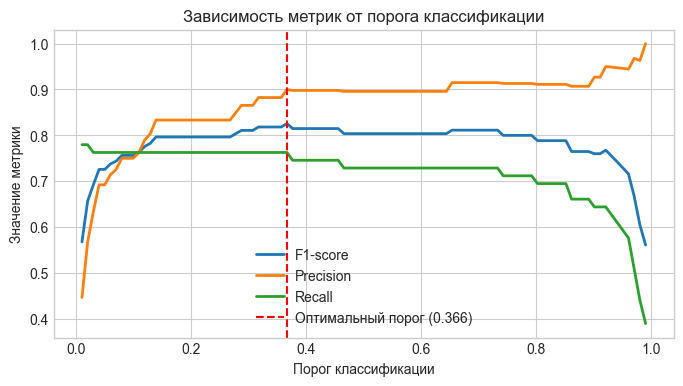

In [23]:
# Получаем предсказания для валидационной выборки
y_val_pred_proba = calibration_model.predict_proba(X_val)[:, 1]

# Создаем список порогов для перебора
thresholds = np.linspace(0.01, 0.99, 100)

# Считаем метрики для каждого порога
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    # Бинаризуем предсказания по порогу
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)
    
    # Считаем метрики
    f1_scores.append(f1_score(y_val, y_val_pred, zero_division=0))
    precision_scores.append(precision_score(y_val, y_val_pred, zero_division=0))
    recall_scores.append(recall_score(y_val, y_val_pred, zero_division=0))

# Находим порог с максимальным F1-score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
optimal_precision = precision_scores[optimal_idx]
optimal_recall = recall_scores[optimal_idx]

print(f"Оптимальный порог: {optimal_threshold:.4f}")
print(f"F1-score на валидации при оптимальном пороге: {optimal_f1:.4f}")
print(f"Precision на валидации при оптимальном пороге: {optimal_precision:.4f}")
print(f"Recall на валидации при оптимальном пороге: {optimal_recall:.4f}")

# Визуализация зависимости метрик от порога
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2)
plt.plot(thresholds, precision_scores, label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, label='Recall', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Оптимальный порог ({optimal_threshold:.3f})')
plt.xlabel('Порог классификации')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от порога классификации')
plt.legend()
plt.show()


In [24]:
# вероятности для тестовой выборки
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Бъём предсказания по оптимальному порогу
y_test_pred_optimal = (y_test_pred_proba >= optimal_threshold).astype(int)

# Считаем метрики на тесте с оптимальным порогом
precision_optimal = precision_score(y_test, y_test_pred_optimal)
recall_optimal = recall_score(y_test, y_test_pred_optimal)
f1_optimal = f1_score(y_test, y_test_pred_optimal)

print('\n' + '='*60)
print("Результаты на тестовой выборке с оптимальным порогом:")
print(f"Precision = {precision_optimal:.4f}")
print(f"Recall = {recall_optimal:.4f}")
print(f"F1-score = {f1_optimal:.4f}")
print('='*60)


Результаты на тестовой выборке с оптимальным порогом:
Precision = 0.9492
Recall = 0.7273
F1-score = 0.8235



Сравнение с дефолтным порогом (0.5):
Precision: 0.9649 → 0.9492
Recall: 0.7143 → 0.7273
F1-score: 0.8209 → 0.8235


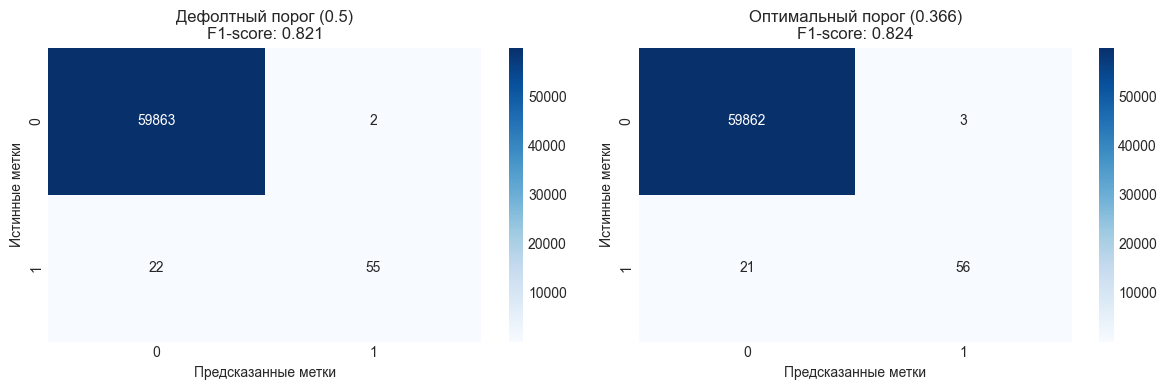

In [25]:
# Сравнение с дефолтным порогом 0.5
y_test_pred_default = (y_test_pred_proba >= 0.5).astype(int)
precision_default = precision_score(y_test, y_test_pred_default)
recall_default = recall_score(y_test, y_test_pred_default)
f1_default = f1_score(y_test, y_test_pred_default)

print("\nСравнение с дефолтным порогом (0.5):")
print(f"Precision: {precision_default:.4f} → {precision_optimal:.4f}")
print(f"Recall: {recall_default:.4f} → {recall_optimal:.4f}")
print(f"F1-score: {f1_default:.4f} → {f1_optimal:.4f}")
print('='*60)

# Визуализируем confusion matrix для обоих порогов
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Confusion matrix для дефолтного порога
cm_default = confusion_matrix(y_test, y_test_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title(f'Дефолтный порог (0.5)\nF1-score: {f1_default:.3f}')
axs[0].set_xlabel("Предсказанные метки")
axs[0].set_ylabel("Истинные метки")

# Confusion matrix для оптимального порога
cm_optimal = confusion_matrix(y_test, y_test_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title(f'Оптимальный порог ({optimal_threshold:.3f})\nF1-score: {f1_optimal:.3f}')
axs[1].set_xlabel("Предсказанные метки")
axs[1].set_ylabel("Истинные метки")

plt.tight_layout()
plt.show()

## Поствывод: 
- **калибровка порга сработала**, жаль что не очень сильно...)